# 프로젝트 : 폐렴아 기다려라!

## 개요 
* ### 폐렴 여부를 진단하는 모델을 생성할 수 있다.
* ### 폐렴 진단기 모델을 변경, 개선할 수 있다.

## 목차
* ### 폐렴을 진단하는 CNN 모델 생성
* ### 모델의 설정 값을 수정 후 성능 변화를 확인
* ### ResNet-18 모델을 생성 후 모델의 성능 확인 

* ### 사용할 라이브러리 호출

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

* ### 사용할 변수 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


* ### 데이터 생성, 데이터 분할

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터, validation 데이터를 모두 filenames에 담기
filenames = tf.io.gfile.glob(TRAIN_PATH) 
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# filenames를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


* ### 정상, 폐렴 이미지 확인

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0747-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person764_bacteria_2668.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


* ### tf.data 생성(mini-batch)

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


* ### 라벨 데이터를 만들어 주는 함수 생성

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있음
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* ### 이미지 데이터 변경

In [10]:
# 이미지를 알맞은 형식으로 변경
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽음
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

* ### train 데이터, validation 데이터 셋 생성

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


* ### test 데이터 셋 생성

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* ### 데이터 변환

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

* ### 데이터 시각화

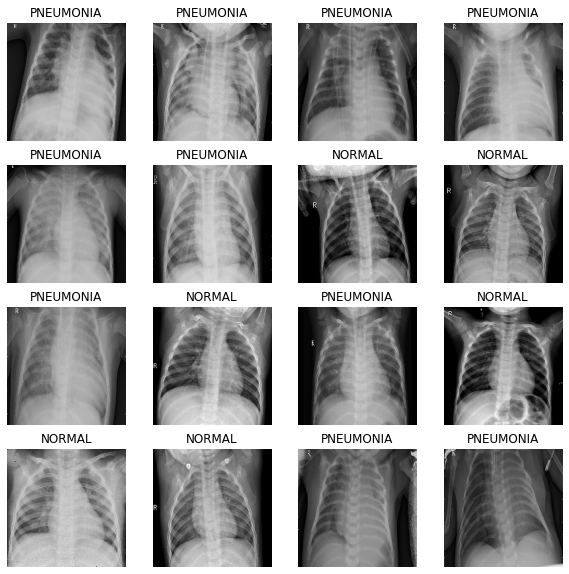

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

* ### CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

* ## CNN 모델 생성

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

* ### 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


* ### 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

* ### 모델 fit

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 98s 207ms/step - loss: 0.3913 - accuracy: 0.8180 - precision: 0.9540 - recall: 0.7938 - val_loss: 0.7172 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 206ms/step - loss: 0.2335 - accuracy: 0.9040 - precision: 0.9744 - recall: 0.8946 - val_loss: 1.1370 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 207ms/step - loss: 0.2098 - accuracy: 0.9227 - precision: 0.9731 - recall: 0.9214 - val_loss: 1.2402 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 210ms/step - loss: 0.2038 - accuracy: 0.9224 - precision: 0.9777 - recall: 0.9167 - val_loss: 0.1089 - val_accuracy: 0.9596 - val_precision: 0.9664 - val_recall: 0.9791
Epoch 5/10
261/261 [==============================] - 57s 217ms/step - loss: 0.1718 - accura

* ### 결과 확인

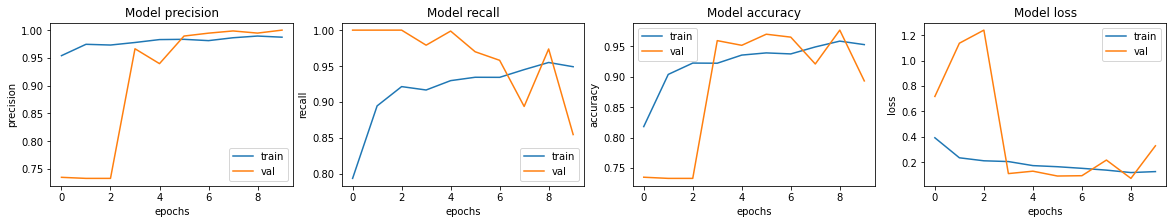

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

* ### 모델 평가

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 112ms/step - loss: 0.4191 - accuracy: 0.8686 - precision: 0.8831 - recall: 0.9103
Loss: 0.4191380441188812,
Accuracy: 0.8685897588729858,
Precision: 0.8830845952033997,
Recall: 0.9102563858032227


* ### precision은 전반적으로 훌륭하고 recall과 accuracy는 변동이 있지만<br> 높은 수준을 보여주며 loss는 꽤 변동이 크지만 나쁘지 않아 보입니다.

* ## 모델의 설정 값 수정 후 변화 확인

In [24]:
BATCH_SIZE_2 = 24
EPOCHS_2 = 15

In [25]:
def model2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        # 필터 수 증가 및 Batch Normalization 추가
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),  # 필터 수 증가
        conv_block(128),  # 필터 수 증가
        
        conv_block(256),
        tf.keras.layers.Dropout(0.1),  # Dropout 비율 감소
        
        conv_block(512),  # 필터 수 증가
        tf.keras.layers.Dropout(0.1),  # Dropout 비율 감소
        
        tf.keras.layers.Flatten(),
        dense_block(1024, 0.7),  # Dense Layer 유닛 수 증가
        dense_block(256, 0.5),   # Dense Layer 유닛 수 증가
        dense_block(128, 0.3),   # Dense Layer 유닛 수 증가
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [26]:
with tf.device('/GPU:0'):
    model2 = model2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE_2,
        epochs = EPOCHS_2,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE_2,
        class_weight = class_weight,
    )

Epoch 1/15
174/174 [==============================] - 53s 224ms/step - loss: 0.3981 - accuracy: 0.8261 - precision: 0.9596 - recall: 0.8007 - val_loss: 0.6388 - val_accuracy: 0.7369 - val_precision: 0.7369 - val_recall: 1.0000
Epoch 2/15
174/174 [==============================] - 38s 216ms/step - loss: 0.2458 - accuracy: 0.9027 - precision: 0.9751 - recall: 0.8917 - val_loss: 0.9853 - val_accuracy: 0.7122 - val_precision: 0.7122 - val_recall: 1.0000
Epoch 3/15
174/174 [==============================] - 39s 226ms/step - loss: 0.2112 - accuracy: 0.9242 - precision: 0.9750 - recall: 0.9218 - val_loss: 2.1576 - val_accuracy: 0.7326 - val_precision: 0.7326 - val_recall: 1.0000
Epoch 4/15
174/174 [==============================] - 39s 227ms/step - loss: 0.1743 - accuracy: 0.9379 - precision: 0.9818 - recall: 0.9339 - val_loss: 1.5696 - val_accuracy: 0.7282 - val_precision: 0.7282 - val_recall: 1.0000
Epoch 5/15
174/174 [==============================] - 41s 237ms/step - loss: 0.1566 - accura

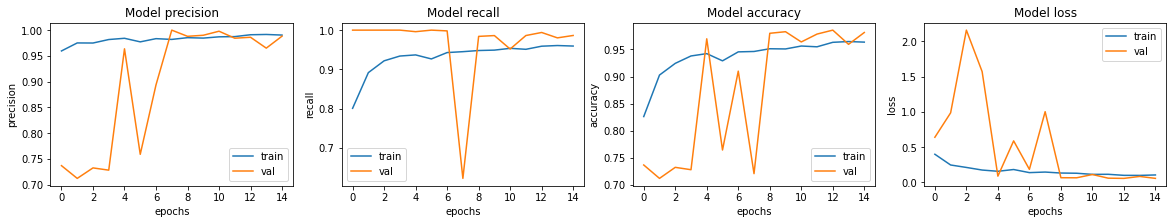

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 0.9099 - accuracy: 0.7724 - precision: 0.7340 - recall: 0.9974
Loss: 0.9098881483078003,
Accuracy: 0.7724359035491943,
Precision: 0.7339622378349304,
Recall: 0.9974358677864075


* ### recall은 높으나 precision이 떨어지고 accuracy과 loss의 <br>변동이 심해 데이터 조정 등의 개선이 필요해 보입니다.

* ## ResNet-18 모델 생성 후 성능 변화 확인

In [32]:
def residual_block(x, filters, stride = 1):
    # Conv 레이어 두 번 적용
    shortcut = x  # 입력을 저장해둠
    
    x = tf.keras.layers.Conv2D(filters, 3, strides = stride, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    
    # 입력을 더해줌 (skip connection)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    
    return x

In [33]:
# 간단하게 ResNet-18 모델 만들기 (사진과 일치하도록 수정)
def resnet18(input_shape=(180, 180, 3), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)
    
    # 처음 Conv 레이어
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Residual Block을 사진에 맞게 2번씩 반복
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2)  # 크기가 줄어듦, stride 적용
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2)  # 크기가 줄어듦, stride 적용
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, stride=2)  # 크기가 줄어듦, stride 적용
    x = residual_block(x, 512)
    
    # 마지막 풀링과 출력 레이어
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)  # 이진 분류를 위한 sigmoid 출력
    
    # 모델 생성
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [34]:
with tf.device('/GPU:0'):
    model3 = resnet18(input_shape=(180, 180, 3), num_classes=1)  # 모델 생성
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model3.compile(
        optimizer='adam',
        loss='binary_crossentropy',  # 이진 분류일 때 binary_crossentropy 사용
        metrics=METRICS
    )
    

In [35]:
with tf.device('/GPU:0'):
    history3 = model3.fit(
        train_ds,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE_2,
        epochs = EPOCHS_2,
        validation_data = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE_2,
        class_weight = class_weight,
    )

Epoch 1/15
174/174 [==============================] - 56s 245ms/step - loss: 0.3521 - accuracy: 0.8678 - precision: 0.9594 - recall: 0.8580 - val_loss: 5.6491 - val_accuracy: 0.7398 - val_precision: 0.7398 - val_recall: 1.0000
Epoch 2/15
174/174 [==============================] - 38s 217ms/step - loss: 0.2027 - accuracy: 0.9203 - precision: 0.9734 - recall: 0.9198 - val_loss: 1.4904 - val_accuracy: 0.7369 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/15
174/174 [==============================] - 39s 222ms/step - loss: 0.1932 - accuracy: 0.9231 - precision: 0.9732 - recall: 0.9210 - val_loss: 3.7114 - val_accuracy: 0.3459 - val_precision: 1.0000 - val_recall: 0.0891
Epoch 4/15
174/174 [==============================] - 39s 224ms/step - loss: 0.1323 - accuracy: 0.9472 - precision: 0.9823 - recall: 0.9454 - val_loss: 0.8353 - val_accuracy: 0.7427 - val_precision: 0.7405 - val_recall: 1.0000
Epoch 5/15
174/174 [==============================] - 40s 230ms/step - loss: 0.1051 - accura

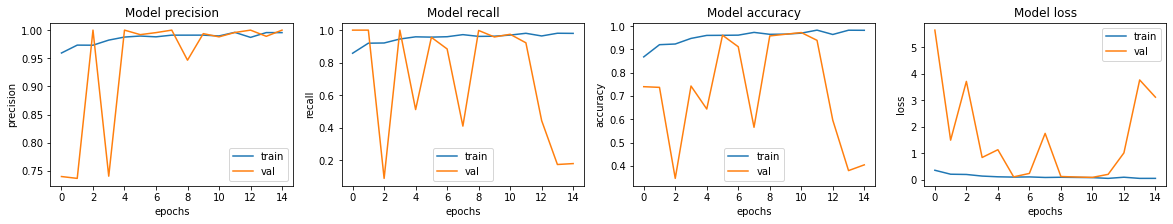

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history3.history[met])
    ax[i].plot(history3.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
loss, accuracy, precision, recall = model3.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 2.3502 - accuracy: 0.4824 - precision: 0.9467 - recall: 0.1821
Loss: 2.350189208984375,
Accuracy: 0.48237180709838867,
Precision: 0.9466666579246521,
Recall: 0.18205128610134125


* ### precision은 높지만 recall 수치가 너무 낮아 놓치는 비율이 크고 <br>accuracy, loss 또한 낮고 변동이 심해서 전체적으로 정확도가<br> 떨어지며 과적합으로 의심되는 부분이 있습니다.

* ### 모델의 개선은 단순한 수치 증가로 나아지지 않으며 복합적으로 작용하는 것을 느낄 수 있었고<br> 그래프를 확인하며 수정하는 방향을 정하는 것이 중요하다는 점도 다시 실감할 수 있었습니다.